In [1]:
import nibabel as nib
import scipy
import io
import os
import random
import math
import numpy as np
from skimage.transform import resize
import glob
import pickle
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm
import torch
from scipy import stats
from monai.networks.nets import unet
from torch.utils.data import DataLoader, Dataset
import csv
import pandas as pd

manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home1/akrami/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('/scratch1/zamzam/HCP_1200.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # skip the header row
    HCP_info = [[row[0], row[4], row[3]] for row in reader]
HCP_info = np.array(HCP_info);

df = pd.read_csv('/scratch1/zamzam/CAMCAN.csv', header=None, skiprows=1)
CamCan_info = df.iloc[:, :3].apply(lambda x: x.str[2:] if x.name == 0 else x.str[0] if x.name == 2 else x).to_numpy()

print(np.shape(HCP_info))
print(np.shape(CamCan_info))

(1206, 3)
(2681, 3)


In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, sample_number = 4, transform=None):
        self.sample_number = sample_number
        self.img_dir = img_dir
        self.files = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.files[idx])
        
        # vol = np.load(img_path)
        # vol = vol['data1']
        vol = pickle.load(open(img_path, 'rb'))
        T1, T2 = vol[0], vol[1]
        
        T1, T2 = T1[:, :-1, :], T2[:, :-1, :]
        T1, T2 = resize(T1, (208, 248, 208)), resize(T2, (208, 248, 208))
        T1, T2 = np.pad(T1, ((0,0), (4,4), (0,0)), mode='constant', constant_values=0), np.pad(T2, ((0,0), (4,4), (0,0)), mode='constant', constant_values=0)
        
        T1, T2 = T1.transpose((2,1,0)), T2.transpose((2,1,0))
        
        msk_normal = (~np.all(T1 == 0,axis=(1,2))) # Remove empty planes
        choices = np.arange(len(msk_normal))[msk_normal]
        
        sample_idx = np.array(choices[2:-10:10])
        
        coord = sample_idx[:, np.newaxis] / T1.shape[0]
        coord = coord - 0.5
        
        T1, T2 = T1[sample_idx], T2[sample_idx]
        max_batch1, max_batch2 = T1.max(axis = 1), T2.max(axis = 1)
        max_batch1, max_batch2 = max_batch1.max(axis = 1), max_batch2.max(axis = 1)
        T1, T2 = T1/max_batch1.reshape((-1, 1, 1)), T2/max_batch2.reshape((-1, 1, 1))
        T1, T2 = T1.astype(np.float32), T2.astype(np.float32)
        
        T1, T2 = torch.from_numpy(T1), torch.from_numpy(T2)
        
        return T1, T2, coord, self.files[idx]

In [4]:
train_dsetHCP = CustomImageDataset(img_dir='/scratch1/zamzam/HCP_nt_train')
train_dsetCamCan = CustomImageDataset(img_dir='/scratch1/akrami/CAMCAN_nt_train')

train_dset = torch.utils.data.ConcatDataset([train_dsetHCP, train_dsetCamCan])
train_loader = DataLoader(train_dset, batch_size=1,shuffle=True,num_workers=1)

val_dsetHCP = CustomImageDataset(img_dir='/scratch1/zamzam/HCP_nt_val')
val_dsetCamCan = CustomImageDataset(img_dir='/scratch1/akrami/CAMCAN_nt_val')

val_dset = torch.utils.data.ConcatDataset([val_dsetHCP, val_dsetCamCan])
val_loader = DataLoader(val_dset, batch_size=1,shuffle=True,num_workers=1)

test_dsetHCP = CustomImageDataset(img_dir='/scratch1/zamzam/HCP_nt_test')
test_dsetCamCan = CustomImageDataset(img_dir='/scratch1/akrami/CAMCAN_nt_test')

test_dset = torch.utils.data.ConcatDataset([test_dsetHCP, test_dsetCamCan])
test_loader = DataLoader(test_dset, batch_size=1,shuffle=True,num_workers=1)

In [5]:
test_loaderHCP = DataLoader(test_dsetHCP, batch_size=1,shuffle=True,num_workers=1)
test_loaderCamCan = DataLoader(test_dsetCamCan, batch_size=1,shuffle=True,num_workers=1)

In [6]:
trainHCP = os.listdir('/scratch1/zamzam/HCP_nt_train')
for i in range(len(trainHCP)):
    trainHCP[i] = trainHCP[i][:-3]
trainCamCan = os.listdir('/scratch1/akrami/CAMCAN_nt_train')
for i in range(len(trainCamCan)):
    trainCamCan[i] = trainCamCan[i][6:-3]
    
trainHCP = np.array(trainHCP).reshape(-1, 1)
trainHCP = np.hstack((trainHCP, np.array(['A'] * len(trainHCP)).reshape(-1, 1)))

trainCamCan = np.array(trainCamCan).reshape(-1, 1)
trainCamCan = np.hstack((trainCamCan,  np.array(['A'] * len(trainCamCan)).reshape(-1, 1)))

for i in range(len(trainHCP)):
    for j in range(len(HCP_info)):
        if trainHCP[i,0] == HCP_info[j,0]:
            trainHCP[i,1] = HCP_info[j,2]
            break
for i in range(len(trainCamCan)):
    for j in range(len(CamCan_info)):
        if trainCamCan[i,0][:] == CamCan_info[j,0]:
            trainCamCan[i,1] = CamCan_info[j,2]
            break
            

In [7]:
confusion_matrix = [[0,0],[0,0]]
confusion_matrix = np.array(confusion_matrix)
for i in range(len(trainHCP)):
    if trainHCP[i,1]=='M':
        confusion_matrix[0,0]+=1
    if trainHCP[i,1]=='F':
        confusion_matrix[0,1]+=1
        
for i in range(len(trainCamCan)):
    if trainCamCan[i,1]=='M':
        confusion_matrix[1,0]+=1
    if trainCamCan[i,1]=='F':
        confusion_matrix[1,1]+=1
        

ratios = np.sum(confusion_matrix)/confusion_matrix
ratios = ratios/np.sum(ratios)
print(confusion_matrix)
print(ratios)

[[357 422]
 [223 234]]
[[0.2011057  0.1701297 ]
 [0.32194949 0.30681511]]


In [8]:
model = unet.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=3).to(device)

optimizer = torch.optim.Adam(model.parameters(), 1e-4)
loss = torch.nn.MSELoss(reduction='none')

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

2411009


In [30]:
model.load_state_dict(torch.load("/scratch1/akrami/Projects/T1_T2/models/Unet/T1_T258_unet_var_s4.pt"))
model.eval();

In [31]:
HCP_loss = []
for i, data in enumerate(tqdm(test_loaderHCP)):


    T1, T2, _, name = data
    name = name[0][:-3]
    T1, T2 = T1.swapaxes(0,1), T2.swapaxes(0,1)
    T1, T2 = T1.to(device), T2.to(device)

    output = model(T1)

    mse = torch.mean(torch.mean(loss(output, T2), dim=(1, 2, 3), keepdim=True)*(208*256)/torch.sum((T1!=0).float(), dim=(1, 2, 3), keepdim=True))

    HCP_loss.append([name, mse.cpu().item()])

100%|██████████| 223/223 [08:35<00:00,  2.31s/it]


In [32]:
CamCan_loss = []
for i, data in enumerate(tqdm(test_loaderCamCan)):


    T1, T2, _, name = data
    name = name[0][6:-3]
    T1, T2 = T1.swapaxes(0,1), T2.swapaxes(0,1)
    T1, T2 = T1.to(device), T2.to(device)

    output = model(T1)
    
    mse = torch.mean(torch.mean(loss(output, T2), dim=(1, 2, 3), keepdim=True)*(208*256)/torch.sum((T1!=0).float(), dim=(1, 2, 3), keepdim=True))

    CamCan_loss.append([name, mse.cpu().item()])

100%|██████████| 131/131 [03:07<00:00,  1.43s/it]


In [33]:
HCP_loss = np.array(HCP_loss);
CamCan_loss = np.array(CamCan_loss);

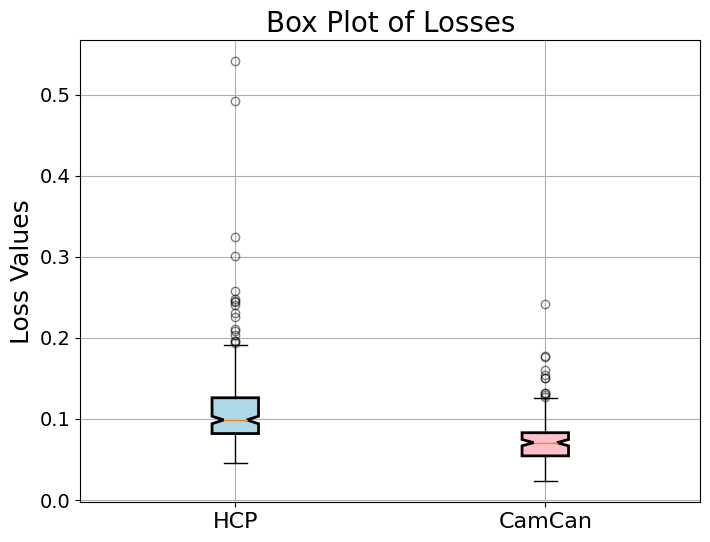

In [34]:
plt.figure(figsize=(8, 6))

# Boxplot
bp = plt.boxplot([HCP_loss[:, 1].astype(float), CamCan_loss[:, 1].astype(float)], patch_artist=True, notch=True, vert=True)

# Box color and linewidth
colors = ['lightblue', 'pink']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_linewidth(2)

# Outlier color and marker
for patch in bp['fliers']:
    patch.set(marker='o', color='black', alpha=0.5)

# Y-axis label and tick labels
plt.xticks([1, 2], ['HCP', 'CamCan'], fontsize=16)
plt.xlabel('', fontsize=18)

# X-axis label and tick labels
plt.yticks(fontsize=14)
plt.ylabel('Loss Values', fontsize=18)

# Title
plt.title('Box Plot of Losses', fontsize=20);
plt.grid(True)

In [35]:
t_statistic, p_value = stats.ttest_ind(HCP_loss[:, 1].astype(float), CamCan_loss[:, 1].astype(float), equal_var=False)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 7.696736006487978
P-Value: 1.4228969630497988e-13


In [36]:
trainHCP = os.listdir('/scratch1/zamzam/HCP_nt_train')
trainCamCan = os.listdir('/scratch1/akrami/CAMCAN_nt_train')

print('number of HCP training samples: ', len(trainHCP), ' and number of CamCan training samples: ', len(trainCamCan))

number of HCP training samples:  779  and number of CamCan training samples:  457


In [37]:
HCP_loss = np.hstack((HCP_loss, np.empty((len(HCP_loss), 1), dtype='U1')))
for i in range(len(HCP_loss)):
    for j in range(len(HCP_info)):
        if HCP_loss[i, 0] == HCP_info[j, 0]:
            HCP_loss[i, 2] = HCP_info[j, 2]
            break
            
CamCan_loss = np.hstack((CamCan_loss, np.empty((len(CamCan_loss), 1), dtype='U1')))
for i in range(len(CamCan_loss)):
    for j in range(len(CamCan_info)):
        if CamCan_loss[i, 0] == CamCan_info[j, 0]:
            CamCan_loss[i, 2] = CamCan_info[j, 2]
            break

In [38]:
gender_loss = np.concatenate((HCP_loss, CamCan_loss), axis=0)
gender_loss = gender_loss[:,1:]

In [39]:
male_loss = gender_loss[gender_loss[:,1]=='M', 0]
female_loss = gender_loss[gender_loss[:,1]=='F', 0]

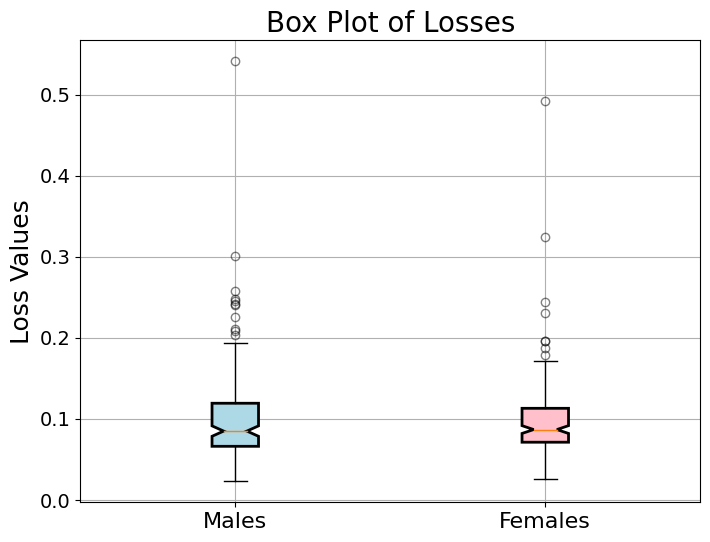

In [40]:
plt.figure(figsize=(8, 6))

# Boxplot
bp = plt.boxplot([male_loss.astype(float), female_loss.astype(float)], patch_artist=True, notch=True, vert=True)

# Box color and linewidth
colors = ['lightblue', 'pink']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_linewidth(2)

# Outlier color and marker
for patch in bp['fliers']:
    patch.set(marker='o', color='black', alpha=0.5)

# Y-axis label and tick labels
plt.xticks([1, 2], ['Males', 'Females'], fontsize=16)
plt.xlabel('', fontsize=18)

# X-axis label and tick labels
plt.yticks(fontsize=14)
plt.ylabel('Loss Values', fontsize=18)

# Title
plt.title('Box Plot of Losses', fontsize=20);
plt.grid(True);

In [41]:
t_statistic, p_value = stats.ttest_ind(male_loss.astype(float), female_loss.astype(float), equal_var=False)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 0.42683514513821574
P-Value: 0.6697901506696602


In [42]:
trainHCP = os.listdir('/scratch1/zamzam/HCP_nt_train')
for i in range(len(trainHCP)):
    trainHCP[i] = trainHCP[i][:-3]
trainCamCan = os.listdir('/scratch1/akrami/CAMCAN_nt_train')
for i in range(len(trainCamCan)):
    trainCamCan[i] = trainCamCan[i][:-3]

for i in range(len(trainHCP)):
    for j in range(len(HCP_info)):
        if trainHCP[i] == HCP_info[j,0]:
            trainHCP[i] = HCP_info[j,2]
            break
for i in range(len(trainCamCan)):
    for j in range(len(CamCan_info)):
        if trainCamCan[i][6:] == CamCan_info[j,0]:
            trainCamCan[i] = CamCan_info[j,2]
            break

train = trainHCP + trainCamCan
m = 0
f = 0
for i in range (len(train)):
    if train[i] == 'M':
        m+=1
    if train[i] == 'F':
        f+=1
print('number of males: ', m, ' and number of females: ', f)

number of males:  580  and number of females:  656


In [43]:
CamCan_loss = CamCan_loss[:,0:2]
CamCan_loss = np.hstack((CamCan_loss, np.empty((len(CamCan_loss), 1), dtype=np.float64)))
for i in range(len(CamCan_loss)):
    for j in range(len(CamCan_info)):
        if CamCan_loss[i, 0] == CamCan_info[j, 0]:
            CamCan_loss[i, 2] = int(float(CamCan_info[j, 1])>50)
            break

In [44]:
old_loss = CamCan_loss[CamCan_loss[:,2]=='1',1]
young_loss = CamCan_loss[CamCan_loss[:,2]=='0',1]

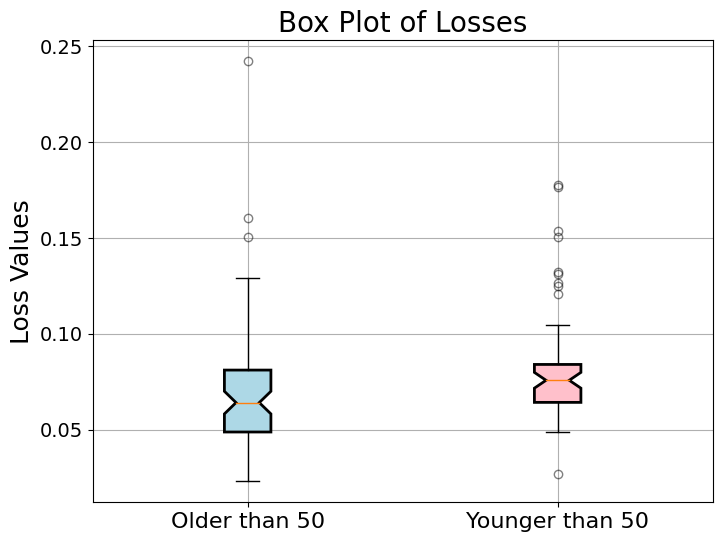

In [47]:
plt.figure(figsize=(8, 6))

# Boxplot
bp = plt.boxplot([old_loss.astype(float), young_loss.astype(float)], patch_artist=True, notch=True, vert=True)

# Box color and linewidth
colors = ['lightblue', 'pink']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_linewidth(2)

# Outlier color and marker
for patch in bp['fliers']:
    patch.set(marker='o', color='black', alpha=0.5)

# Y-axis label and tick labels
plt.xticks([1, 2], ['Older than 50', 'Younger than 50'], fontsize=16)
plt.xlabel('', fontsize=18)

# X-axis label and tick labels
plt.yticks(fontsize=14)
plt.ylabel('Loss Values', fontsize=18)

# Title
plt.title('Box Plot of Losses', fontsize=20);
plt.grid(True);

In [49]:
t_statistic, p_value = stats.ttest_ind(old_loss.astype(float), young_loss.astype(float), equal_var=False)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -2.3623055625120557
P-Value: 0.019682107943930546
